# TP : Word Embeddings for Classification


```yaml
Name: Jiale KANG, Shujian YANG
Date: April 16, 2024
```

---


## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

In [ ]:
from sklearn.model_selection import train_test_split
import nltk
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models import Word2Vec

## Loading data

Let's load the data: take a first look.

In [2]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [3]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [4]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [5]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [6]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 2
train_texts = texts
train_labels = labels
texts_reduced = train_texts[0::k]
labels_reduced = train_labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 47156


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_reduced, labels_reduced, test_size=0.2, random_state=42)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
nltk.download('stopwords')

def pre_process(texts):
    # lowercase
    texts = [text.lower() for text in texts]
    # remove puntuation
    texts = [re.sub(r'[^\w\s]', '', text) for text in texts]
    # tokenization
    texts_token = [nltk.word_tokenize(text) for text in texts]
    # stemming
    stemmer = nltk.SnowballStemmer('french')
    texts_stem = [[stemmer.stem(word) for word in text] for text in texts_token]
    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('french'))
    texts_stop = [[word for word in text if word not in stop_words] for text in texts_stem]
    return texts_stop
    

[nltk_data] Downloading package stopwords to C:\Users\Thomas
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
# Look at the data and apply the appropriate pre-processing
train_texts_clean = pre_process(train_texts)
test_texts_clean = pre_process(test_texts)


Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def vocabulary(corpus, count_threshold=0, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency   
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    for sent in corpus:
        for word in sent.split():
            word_counts[word] = word_counts.get(word, 0) + 1
    
    filtered_word_counts = {word:count for word,count in word_counts.items() if count > count_threshold} # Filter according to count_threhshold        
    sorted_words = sorted(filtered_word_counts, key=filtered_word_counts.get, reverse=True) # Extract the words according to frequency
    filtered_words = sorted_words[:voc_threshold] if voc_threshold>0 else sorted_words # Remove the words above voc-threshold
    words = filtered_words + ["UNK"] # Add UNK
    vocabulary = {word: i for i, word in enumerate(words)} # Create vocabulary from "words"
    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

In [11]:
voc, count = vocabulary([' '.join(text) for text in train_texts_clean], count_threshold=10, voc_threshold=0)
print(voc)
print(count)

{'spécial': 0, 'mention': 1, 'scienc': 2, 'diplôm': 3, 'sant': 4, 'technolog': 5, 'ingénieur': 6, 'gestion': 7, 'manag': 8, 'national': 9, 'domain': 10, 'droit': 11, 'mast': 12, 'informat': 13, 'system': 14, 'industriel': 15, 'professionnel': 16, 'gen': 17, 'supérieur': 18, 'social': 19, 'méti': 20, 'option': 21, 'commun': 22, 'langu': 23, 'humain': 24, 'lunivers': 25, 'art': 26, 'appliqu': 27, 'développ': 28, 'lecol': 29, 'final': 30, 'product': 31, 'ingénier': 32, 'linstitut': 33, 'respons': 34, 'econom': 35, 'fich': 36, 'projet': 37, 'recherch': 38, 'polytechn': 39, 'économ': 40, 'lettr': 41, 'environ': 42, 'matérial': 43, 'réseau': 44, 'international': 45, 'sécur': 46, 'lécol': 47, 'biolog': 48, 'physiqu': 49, 'mécan': 50, 'techniqu': 51, 'marketing': 52, 'lenviron': 53, 'chim': 54, 'qualit': 55, 'organis': 56, 'industr': 57, 'licenc': 58, 'chef': 59, 'mathémat': 60, 'commerc': 61, 'mainten': 62, 'activ': 63, 'télécommun': 64, 'expert': 65, 'dingénieur': 66, 'numer': 67, 'universit

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

In [12]:
print(len(voc))

1507


**Answer:**

Our current vocabulary size is 1507 (as shown above). The appropriate size will depend on the importance of the vocabulary and the different tasks:
- For tasks centered around broad, general topics or macro-topics, a smaller vocabulary might be enough.
- If the task is highly specified, we need more vocabularies to observe certain detailed words.

Thus, further pre-processing is also depend on the tasks that we meet. We can use the following techniques that we learnt from the course:
- Lemmatization: Reducing words to their base or root form
- Use of N-Grams: Incorporating n-grams (e.g., bi-grams and tri-grams) can capture more contextual information than single words

---

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

Accuracy: 0.268871925360475
                 precision    recall  f1-score   support

1-environnement       0.25      0.23      0.24      1209
      2-defense       0.33      0.10      0.15       639
   3-patrimoine       0.26      0.11      0.15       389
     4-economie       0.29      0.15      0.19       178
    5-recherche       0.34      0.14      0.20       163
     6-nautisme       0.25      0.10      0.14       272
 7-aeronautique       0.18      0.06      0.09       347
     8-securite       0.23      0.29      0.25      1146
   9-multimedia       0.41      0.15      0.22       124
 10-humanitaire       0.37      0.16      0.23       370
   11-nucleaire       0.28      0.64      0.39      1957
     12-enfance       0.21      0.08      0.11       505
  13-saisonnier       0.20      0.07      0.10       462
  14-assistance       0.23      0.14      0.18       802
       15-sport       0.28      0.15      0.19       148
  16-ingenierie       0.32      0.25      0.28       721

 

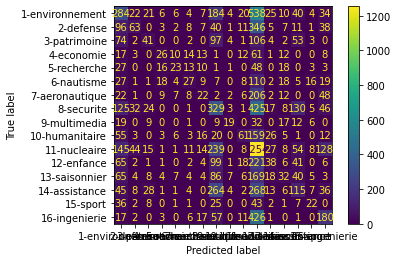

In [13]:
# CountVectorizer + Logistic Regression
plot_flag = True

pipline_counterLR = Pipeline([
    ('countervec', CountVectorizer(vocabulary=[word.lower() for word in voc])),
    ('model', 
     LogisticRegression(
         max_iter=1000, 
         multi_class='ovr', 
         solver='liblinear', 
         random_state=42, 
         fit_intercept=True, 
         penalty='l1',
         C=0.19938842909500154
        ))
])
pipline_counterLR.fit([' '.join(text) for text in train_texts_clean], train_labels)
predictions = pipline_counterLR.predict([' '.join(text) for text in test_texts_clean])
print('Accuracy:', accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions, target_names=Categories))

if plot_flag:
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Categories)
    disp.plot()
    plt.show()

Accuracy: 0.2737489397794741
                 precision    recall  f1-score   support

1-environnement       0.24      0.28      0.26      1209
      2-defense       0.39      0.10      0.16       639
   3-patrimoine       0.23      0.07      0.11       389
     4-economie       0.32      0.18      0.23       178
    5-recherche       0.37      0.09      0.14       163
     6-nautisme       0.18      0.06      0.09       272
 7-aeronautique       0.15      0.05      0.07       347
     8-securite       0.22      0.31      0.26      1146
   9-multimedia       0.57      0.06      0.12       124
 10-humanitaire       0.37      0.19      0.25       370
   11-nucleaire       0.30      0.63      0.40      1957
     12-enfance       0.24      0.07      0.10       505
  13-saisonnier       0.28      0.10      0.15       462
  14-assistance       0.25      0.16      0.19       802
       15-sport       0.31      0.11      0.17       148
  16-ingenierie       0.31      0.26      0.28       721



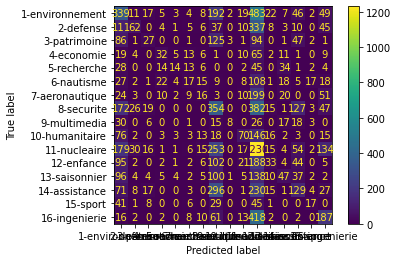

In [14]:
# TF-IDF
pipline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=[word.lower() for word in voc])),
    ('model', 
     LogisticRegression(
         max_iter=1000, 
         multi_class='ovr', 
         solver='saga', 
         random_state=42, 
         fit_intercept=True, 
         penalty='l2',
         C=0.2021867460428368
        ))
])
pipline_tfidf.fit([' '.join(text) for text in train_texts_clean], train_labels)
predictions = pipline_tfidf.predict([' '.join(text) for text in test_texts_clean])
print('Accuracy:', accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions, target_names=Categories))


if plot_flag:
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Categories)
    disp.plot()
    plt.show()


#### Remarque for parameter choice:

In order to find the best parameters of our model, we used ``` optuna``` to search for the best parameters that our logistic regression can bring. The code block below shows how it works:

In [ ]:
# import optuna
# def objective(trial):
#     # Define hyperparameters to search
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#     solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
#     C = trial.suggest_float('C', 0.1, 5.0)
    
#     # Create pipeline
#     pipeline = Pipeline([
#         ('countervec', TfidfVectorizer(
#             vocabulary=[word.lower() for word in voc]
#         )),
#         ('model', LogisticRegression(
#             max_iter=2000,
#             multi_class='ovr',
#             solver=solver,
#             random_state=42,
#             penalty=penalty,
#             C=C
#         ))
#     ])
    
#     # Fit pipeline
#     pipeline.fit([' '.join(text) for text in train_texts_clean], train_labels)
    
#     # Predict and calculate accuracy
#     predictions = pipeline.predict([' '.join(text) for text in test_texts_clean])
#     accuracy = accuracy_score(test_labels, predictions)
    
#     return accuracy

# # Create Optuna study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Print the best parameters found
# print(f"Best trial: {study.best_trial.params}")
# print(f"Best accuracy: {study.best_trial.value}")

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

Accuracy: 0.2675996607294317
                 precision    recall  f1-score   support

1-environnement       0.24      0.26      0.25      1209
      2-defense       0.34      0.10      0.16       639
   3-patrimoine       0.24      0.08      0.12       389
     4-economie       0.26      0.15      0.19       178
    5-recherche       0.38      0.13      0.20       163
     6-nautisme       0.17      0.10      0.13       272
 7-aeronautique       0.14      0.04      0.07       347
     8-securite       0.23      0.31      0.26      1146
   9-multimedia       0.40      0.10      0.16       124
 10-humanitaire       0.33      0.20      0.25       370
   11-nucleaire       0.30      0.60      0.40      1957
     12-enfance       0.20      0.07      0.11       505
  13-saisonnier       0.20      0.07      0.11       462
  14-assistance       0.24      0.17      0.20       802
       15-sport       0.26      0.11      0.15       148
  16-ingenierie       0.29      0.25      0.27       721



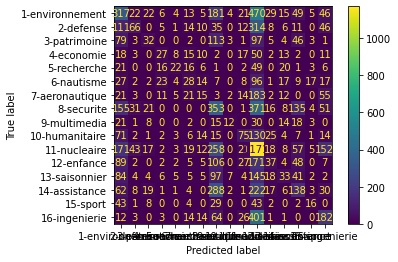

In [15]:
# TruncatedSVD
n_topics = 300

vectorizer = TfidfVectorizer(vocabulary=[word.lower() for word in voc])
train_texts_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_texts_clean])
test_texts_tfidf = vectorizer.transform([' '.join(text) for text in test_texts_clean])

svd = TruncatedSVD(n_components=n_topics, random_state=42)
train_texts_svd = svd.fit_transform(train_texts_tfidf)
test_texts_svd = svd.transform(test_texts_tfidf)

# Logistic Regression
model = LogisticRegression(
         max_iter=1000, 
         multi_class='ovr', 
         solver='liblinear', 
         random_state=42, 
         fit_intercept=True, 
         penalty='l2',
         C=0.5351208229170836
        )
model.fit(train_texts_svd, train_labels)
predictions = model.predict(test_texts_svd)
print('Accuracy:', accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions, target_names=Categories))

if plot_flag:
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Categories)
    disp.plot()
    plt.show()

Accuracy: 0.26569126378286684
                 precision    recall  f1-score   support

1-environnement       0.24      0.27      0.25      1209
      2-defense       0.38      0.09      0.15       639
   3-patrimoine       0.23      0.07      0.10       389
     4-economie       0.30      0.15      0.20       178
    5-recherche       0.35      0.07      0.12       163
     6-nautisme       0.14      0.04      0.07       272
 7-aeronautique       0.13      0.03      0.05       347
     8-securite       0.23      0.32      0.27      1146
   9-multimedia       0.54      0.06      0.10       124
 10-humanitaire       0.31      0.16      0.21       370
   11-nucleaire       0.29      0.64      0.39      1957
     12-enfance       0.21      0.05      0.08       505
  13-saisonnier       0.20      0.06      0.09       462
  14-assistance       0.25      0.15      0.19       802
       15-sport       0.30      0.09      0.14       148
  16-ingenierie       0.31      0.23      0.27       721


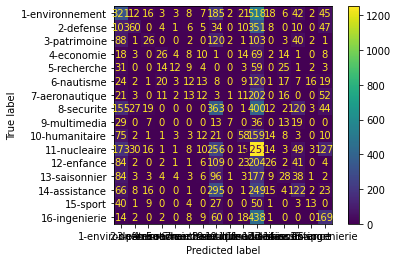

In [16]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
train_texts_lda = lda.fit_transform(train_texts_tfidf)
test_texts_lda = lda.transform(test_texts_tfidf)

# Logistic Regression
model = LogisticRegression(
         max_iter=1000, 
         multi_class='ovr', 
         solver='saga', 
         random_state=42, 
         fit_intercept=True, 
         penalty='l2',
         C=0.2021867460428368
        )
model.fit(train_texts_svd, train_labels)
predictions = model.predict(test_texts_svd)
print('Accuracy:', accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions, target_names=Categories))

if plot_flag:
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Categories)
    disp.plot()
    plt.show()

We tried some other Machine Learning model for result comparison:

- SVM
- Random Forest

In [17]:
svm_model = SVC(kernel='linear')
svm_model.fit(train_texts_svd, train_labels)
svm_predictions = svm_model.predict(test_texts_svd)

print('Accuracy:', accuracy_score(test_labels, svm_predictions))
print(classification_report(test_labels, svm_predictions, target_names=Categories))

Accuracy: 0.27470313825275655
                 precision    recall  f1-score   support

1-environnement       0.25      0.28      0.27      1209
      2-defense       0.33      0.08      0.13       639
   3-patrimoine       0.28      0.07      0.12       389
     4-economie       0.22      0.17      0.19       178
    5-recherche       0.29      0.12      0.17       163
     6-nautisme       0.18      0.11      0.14       272
 7-aeronautique       0.17      0.07      0.10       347
     8-securite       0.23      0.35      0.28      1146
   9-multimedia       0.43      0.10      0.16       124
 10-humanitaire       0.30      0.18      0.22       370
   11-nucleaire       0.30      0.64      0.41      1957
     12-enfance       0.24      0.03      0.06       505
  13-saisonnier       0.21      0.05      0.08       462
  14-assistance       0.27      0.13      0.18       802
       15-sport       0.26      0.16      0.19       148
  16-ingenierie       0.31      0.23      0.26       721


In [18]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_texts_svd, train_labels)
rf_predictions = rf_model.predict(test_texts_svd)

In [19]:
print('Accuracy:', accuracy_score(test_labels, rf_predictions))
print(classification_report(test_labels, rf_predictions, target_names=Categories))

Accuracy: 0.17514843087362172
                 precision    recall  f1-score   support

1-environnement       0.14      0.14      0.14      1209
      2-defense       0.14      0.11      0.12       639
   3-patrimoine       0.12      0.10      0.11       389
     4-economie       0.11      0.10      0.11       178
    5-recherche       0.17      0.12      0.14       163
     6-nautisme       0.13      0.14      0.14       272
 7-aeronautique       0.04      0.03      0.03       347
     8-securite       0.12      0.13      0.12      1146
   9-multimedia       0.14      0.10      0.12       124
 10-humanitaire       0.19      0.19      0.19       370
   11-nucleaire       0.28      0.35      0.31      1957
     12-enfance       0.09      0.07      0.08       505
  13-saisonnier       0.09      0.06      0.07       462
  14-assistance       0.12      0.11      0.12       802
       15-sport       0.16      0.14      0.15       148
  16-ingenierie       0.23      0.26      0.25       721


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

**Answers:**
We need to choose the appropriate number of topics. If the number is too high, the granularity would be too fine and specific, which will lose the objective of topic modelling. Inversely, if the number is too low, the topics would be too broad. 

In order to choose the appropriate topic number, we first need to have a empirical understanding of the given data and protential scale of the topic number to be chosen. Then, we can use Grid search methods to find the best parameters. We can also analyse the outcome by finding the stabilization point and adopting the elbow method. 

---

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [21]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    Vocab_idx = {word: i for i, word in enumerate(vocabulary)}
    for sent in corpus:
        # Get the sentence
        sent =  sent.split()

        sent_idx =  [Vocab_idx.get(word, l-1) for word in sent]
        # Avoid one-word sentences - can create issues in normalization: 
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx_i in enumerate(sent_idx):
            if window > 0:
                # Window context: max and min are used to stay within sentence boundaries
                l_ctx_idx = sent_idx[max(0, i-window):min(len(sent_idx), i + window + 1)]
            else:
                # Full sentence context
                l_ctx_idx = sent_idx

            # Update the matrix for left context
            for j, ctx_idx in enumerate(l_ctx_idx):
                if ctx_idx != idx_i:
                    M[idx_i, ctx_idx] += 1
                    M[ctx_idx, idx_i] += 1        
    return M  

<div class='alert alert-block alert-info'>
            Code:</div>

In [28]:
# k = 1

# train_texts = texts[0::k]
# train_labels = labels[0::k]

In [46]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
co_occurance_Matrix =  co_occurence_matrix(train_texts, voc, window=2)
print(co_occurance_Matrix)

[[      0.       0.       0. ...       0.       0.       0.]
 [      0.   15008.       0. ...       0.       0.   52614.]
 [      0.       0.       0. ...       0.       0.       0.]
 ...
 [      0.       0.       0. ...       0.       0.       0.]
 [      0.       0.       0. ...       0.       0.       0.]
 [      0.   52614.       0. ...       0.       0. 7930940.]]


In [47]:
n_topics = 300
svd = TruncatedSVD(n_components=n_topics)
X_topics = svd.fit_transform(co_occurance_Matrix)
print(X_topics)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.27129876e+04  1.46638607e+04  3.70320550e+02 ...  1.13791472e-36
  -1.08913117e-36  1.69879272e-38]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.93128587e+06 -9.53575375e+01 -4.68561424e+01 ... -3.53928668e-37
   3.25815749e-37 -5.88212643e-39]]


<div class='alert alert-block alert-info'>
            Code:</div>

In [22]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = [vocabulary.get(word) for word in text.split() if word in vocabulary]
        # Indexes of words in the sentence obtained thanks to the vocabulary
        if indexes:
            sentrep = np_func([embeddings[idx] for idx in indexes], axis=0)
        else:
            sentrep = np.zeros(embeddings.shape[1])
        
        # Embeddings of words in the sentence, aggregated thanks to the function
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [43]:
# Obtain document representations, apply the classifier
doc_representation = sentence_representations(texts_reduced, voc, X_topics, np_func=np.mean)

X_train_doc, X_test_doc, y_train_doc, y_test_doc = train_test_split(doc_representation, labels_reduced, test_size=0.2, random_state=108)

model.fit(X_train_doc, y_train_doc)
y_pred_doc = model.predict(X_test_doc)

print(classification_report(y_test_doc, y_pred_doc,target_names=Categories))

                 precision    recall  f1-score   support

1-environnement       0.23      0.04      0.06      1181
      2-defense       0.28      0.01      0.03       604
   3-patrimoine       0.00      0.00      0.00       413
     4-economie       0.18      0.03      0.05       171
    5-recherche       0.16      0.03      0.04       155
     6-nautisme       0.09      0.01      0.02       266
 7-aeronautique       0.15      0.01      0.02       368
     8-securite       0.28      0.11      0.15      1171
   9-multimedia       0.33      0.03      0.06       132
 10-humanitaire       0.50      0.04      0.08       405
   11-nucleaire       0.21      0.91      0.34      1880
     12-enfance       0.00      0.00      0.00       516
  13-saisonnier       0.23      0.03      0.05       485
  14-assistance       0.17      0.01      0.02       776
       15-sport       0.00      0.00      0.00       166
  16-ingenierie       0.26      0.06      0.10       743

       accuracy              

## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [23]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(count))
model.build_vocab_from_freq(count)

<div class='alert alert-block alert-info'>
            Code:</div>

In [24]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = [nltk.word_tokenize(text) for text in train_texts]

In [25]:
model.train(preprocessed_corpus, total_examples=len(preprocessed_corpus), epochs=30, report_delay=1)

(375655, 13757400)

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [26]:
doc_representation = sentence_representations(texts_reduced, voc, model.wv.vectors, np_func=np.mean)

X_train_doc, X_test_doc, y_train_doc, y_test_doc = train_test_split(doc_representation, labels_reduced, test_size=0.2, random_state=108)

Accuracy: 0.2063189143341815
                 precision    recall  f1-score   support

1-environnement       0.23      0.03      0.05      1181
      2-defense       0.00      0.00      0.00       604
   3-patrimoine       0.00      0.00      0.00       413
     4-economie       0.19      0.02      0.04       171
    5-recherche       0.29      0.01      0.02       155
     6-nautisme       0.00      0.00      0.00       266
 7-aeronautique       0.11      0.00      0.01       368
     8-securite       0.28      0.10      0.14      1171
   9-multimedia       0.00      0.00      0.00       132
 10-humanitaire       0.00      0.00      0.00       405
   11-nucleaire       0.20      0.95      0.33      1880
     12-enfance       0.00      0.00      0.00       516
  13-saisonnier       0.33      0.00      0.00       485
  14-assistance       0.00      0.00      0.00       776
       15-sport       0.00      0.00      0.00       166
  16-ingenierie       0.22      0.02      0.03       743



c:\Users\Thomas Yang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thomas Yang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thomas Yang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


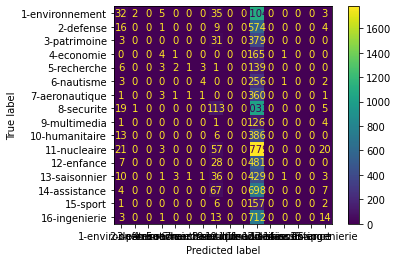

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

model = LogisticRegression(
         max_iter=1000, 
         multi_class='ovr', 
         solver='liblinear', 
         random_state=42, 
         fit_intercept=True, 
         penalty='l1'
        )
model.fit(X_train_doc, y_train_doc)
predictions = model.predict(X_test_doc)
print('Accuracy:', accuracy_score(y_test_doc, predictions))
print(classification_report(y_test_doc, predictions, target_names=Categories))

if plot_flag:
    cm = confusion_matrix(y_test_doc, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Categories)
    disp.plot()
    plt.show()

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 

**Answer:**

The result is still quite low with average accuracy less than 30%. This is might because of two reasons: the data and the model. 

The original data is very imbalanced. We may use better data preprocessing techniques, like over-sampling, data augmentation, to counter the problem.

The model selection is also crucial for good performance. The ```LogisticRegression``` model perhaps is not a good classifier for our task. We also tried Support Vector Machine and Random Forest. The SVM seems to be a bit better. But, the overall performances of the classic machine learning methods are not satisfactory. Deep learning methods, like CNN, ResNet, could be explored in the furture.